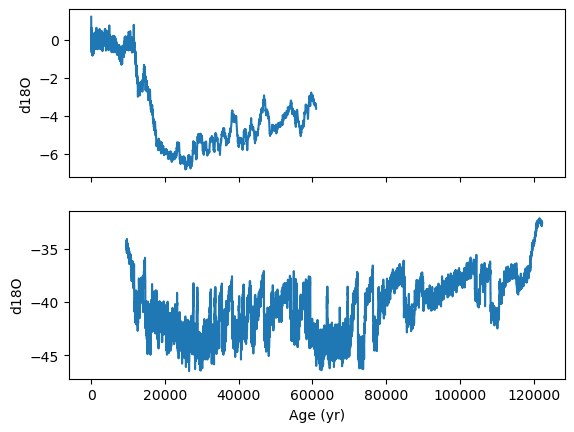

Antarctic Fivecore:
Start age:  0
End age:  61000
NGRIP:
Start age:  9540
End age:  122280


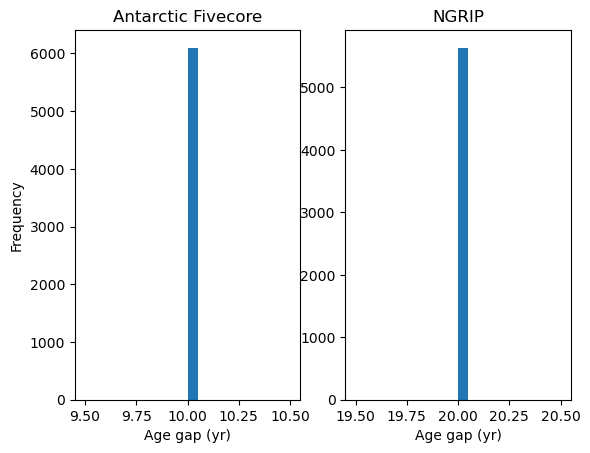

In [1]:
import pandas as pd


path = "D:/VScode/bipolar_seesaw_CCM/ice_core_data/Ant_Gre.xlsx"

# Loading the sheets Antarctic_Fivecore and NGRIP
df_ant = pd.read_excel(path, sheet_name="Antarctic_Fivecore")
df_ngrip = pd.read_excel(path, sheet_name="NGRIP")


import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].plot(df_ant["age"], df_ant["d18O"], label="Antarctic Fivecore")
axs[1].plot(df_ngrip["age"], df_ngrip["d18O"], label="NGRIP")
axs[0].set_ylabel("d18O")
axs[1].set_xlabel("Age (yr)")
axs[1].set_ylabel("d18O")
plt.show()

# print the start and end age of both data
print("Antarctic Fivecore:")
print("Start age: ", df_ant["age"].min())
print("End age: ", df_ant["age"].max())
print("NGRIP:")
print("Start age: ", df_ngrip["age"].min())
print("End age: ", df_ngrip["age"].max())

# from age small to large, for the same age value in ngrip, remove the dupilcate
df_ngrip = df_ngrip.drop_duplicates("age", keep="first")


# plot 1 by 2 histograms to show the distribution of age gaps in both data
fig, axs = plt.subplots(1, 2)
axs[0].hist(df_ant["age"].diff().dropna(), bins=20)
axs[0].set_title("Antarctic Fivecore")
axs[0].set_xlabel("Age gap (yr)")
axs[0].set_ylabel("Frequency")
axs[1].hist(df_ngrip["age"].diff().dropna(), bins=20)
axs[1].set_title("NGRIP")
axs[1].set_xlabel("Age gap (yr)")
plt.show()

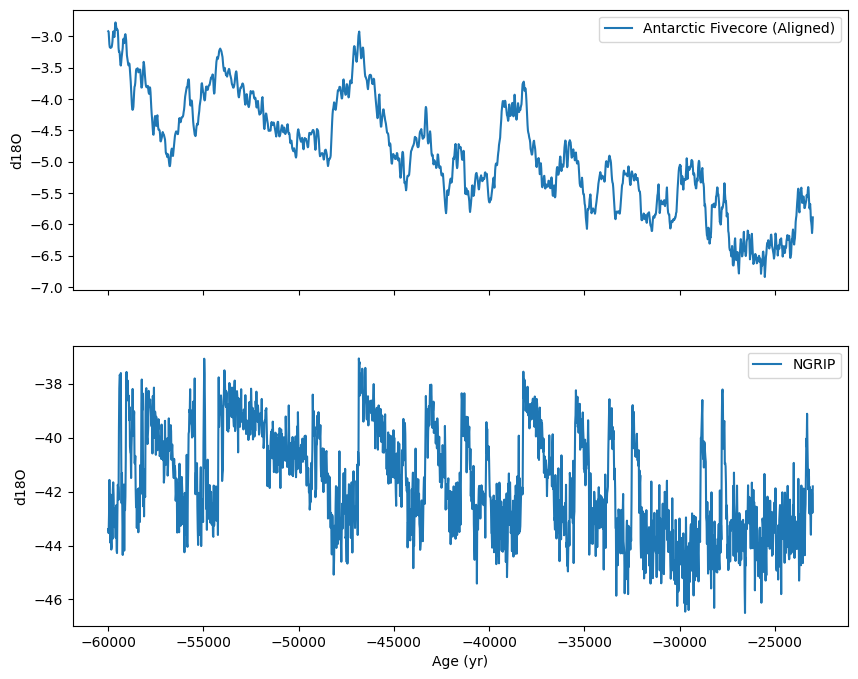

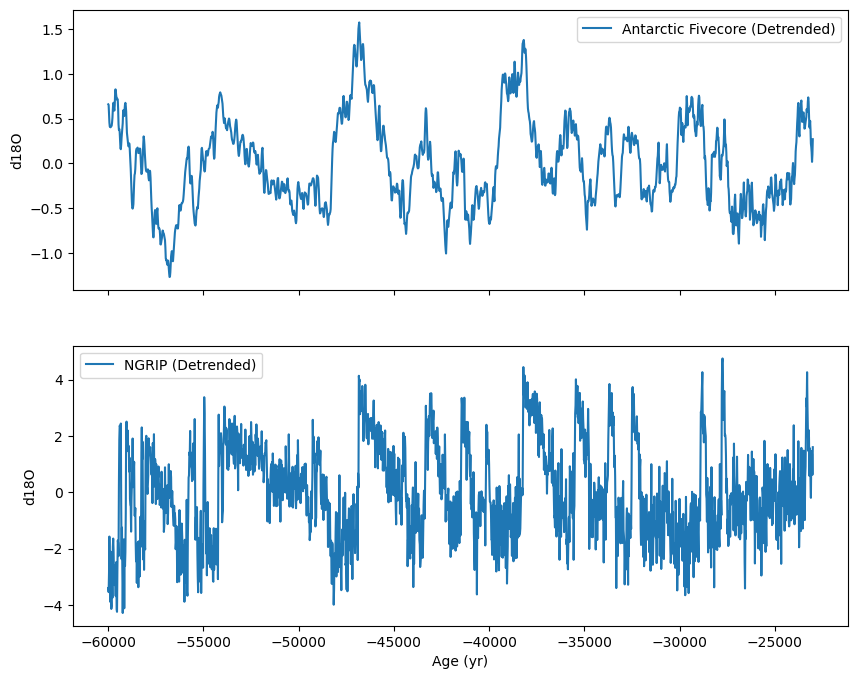

Length of the new time axis:  1851


In [2]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt


# Convert dataframes to ndarrays
age_ant = df_ant["age"].values - 50
d18O_ant = df_ant["d18O"].values
age_ngrip = df_ngrip["age"].values
d18O_ngrip = df_ngrip["d18O"].values

# Interpolate both datasets
new_time_axis = np.arange(23000, 60001, 20)
interp_ant = interp1d(age_ant, d18O_ant, bounds_error=False, fill_value="extrapolate")
interp_ngrip = interp1d(age_ngrip, d18O_ngrip, bounds_error=False, fill_value="extrapolate")

# Interpolated data
interpolated_d18O_ant = interp_ant(new_time_axis)
interpolated_d18O_ngrip = interp_ngrip(new_time_axis)

new_time_axis=new_time_axis*-1

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
axs[0].plot(new_time_axis, interpolated_d18O_ant, label="Antarctic Fivecore (Aligned)")
axs[1].plot(new_time_axis, interpolated_d18O_ngrip, label="NGRIP")
axs[0].set_ylabel("d18O")
axs[1].set_xlabel("Age (yr)")
axs[1].set_ylabel("d18O")
axs[0].legend()
axs[1].legend()
plt.show()


# detrend the data
from scipy.signal import detrend
detrended_d18O_ant = detrend(interpolated_d18O_ant, type="linear")
detrended_d18O_ngrip = detrend(interpolated_d18O_ngrip, type="linear")

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
axs[0].plot(new_time_axis, detrended_d18O_ant, label="Antarctic Fivecore (Detrended)")
axs[1].plot(new_time_axis, detrended_d18O_ngrip, label="NGRIP (Detrended)")
axs[0].set_ylabel("d18O")
axs[1].set_xlabel("Age (yr)")
axs[1].set_ylabel("d18O")
axs[0].legend()
axs[1].legend()
plt.show()

# print the length of the new time
print("Length of the new time axis: ", len(new_time_axis))


# Find proper E and tau

In [7]:
import pandas as pd

df_ant_edm = pd.DataFrame({
    'Time': new_time_axis,          # your time index (length 1851)
    'd18O': detrended_d18O_ant      # your detrended data
})

df_ngrip_edm = pd.DataFrame({
    'Time': new_time_axis,
    'd18O': detrended_d18O_ngrip
})


import pyEDM
import matplotlib.pyplot as plt

def find_best_E(df, E_values, data_column='d18O', 
                lib=None, pred=None, tau=-1, Tp=1, noTime=False):
    """
    df          : DataFrame with columns [Time, data_column]
    E_values    : iterable of embedding dimensions to test
    data_column : name of the column to forecast
    lib         : string specifying the library rows, e.g. '1 900'
    pred        : string specifying the prediction rows, e.g. '901 1851'
    tau         : embedding time-lag (default -1 = let pyEDM guess or use default)
    Tp          : prediction horizon (default 1)
    noTime      : if True, pyEDM will assume there's no separate time column
    """
    N = len(df)
    if lib is None or pred is None:
        # Example: first half for library, second half for prediction
        mid = N // 2
        lib  = f"1 {mid}"
        pred = f"{mid+1} {N}"
    
    results = {}
    for E in E_values:
        # Run Simplex
        simplex_out = pyEDM.Simplex(
            dataFrame = df,
            columns   = data_column,  # library columns
            target    = data_column,  # predict the same variable
            lib       = lib,
            pred      = pred,
            E         = E,
            Tp        = Tp,
            tau       = tau,
            knn       = 0,        # 0 => use E+1 neighbors
            embedded  = False,    # let pyEDM embed for us
            noTime    = noTime,   # if the first column is Time, set noTime=False
            showPlot  = False
        )
        
        # simplex_out is a DataFrame with columns ["Time","Observations","Predictions"]
        obs = simplex_out["Observations"].values
        pred_ = simplex_out["Predictions"].values
        
        # Compute correlation, ignoring NaNs
        valid_idx = ~np.isnan(obs) & ~np.isnan(pred_)
        if np.sum(valid_idx) > 1:
            rho_val = np.corrcoef(obs[valid_idx], pred_[valid_idx])[0,1]
        else:
            rho_val = np.nan
        
        results[E] = rho_val
    
    return results


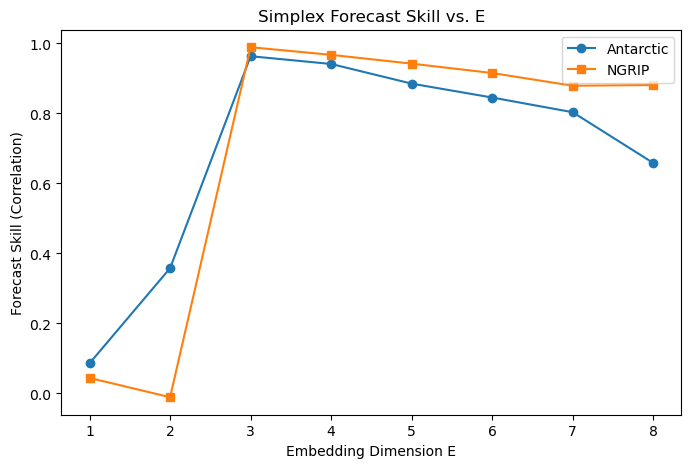

In [23]:
# Range of E to test
E_candidates = range(1, 9)  # 1..8

# Antarctic
ant_results = find_best_E(
    df_ant_edm, 
    E_values = E_candidates, 
    data_column = 'd18O',
    tau = 50,           # Example: use time-lag of 1
    Tp = 50,           # 1-step-ahead forecast
    lib='1 900',      # e.g. rows 1..900 as library
    pred='901 1851',  # rows 901..1851 as prediction
    noTime=False
)

# NGRIP
ngrip_results = find_best_E(
    df_ngrip_edm, 
    E_values = E_candidates, 
    data_column = 'd18O',
    tau = 50,
    Tp = 50,
    lib='1 900',
    pred='901 1851',
    noTime=False
)

# Convert dictionary to lists for plotting
E_vals = sorted(ant_results.keys())
ant_rho = [ant_results[E] for E in E_vals]
ngrip_rho = [ngrip_results[E] for E in E_vals]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(E_vals, ant_rho, marker='o', label='Antarctic')
plt.plot(E_vals, ngrip_rho, marker='s', label='NGRIP')
plt.xlabel('Embedding Dimension E')
plt.ylabel('Forecast Skill (Correlation)')
plt.title('Simplex Forecast Skill vs. E')
plt.legend()
plt.show()


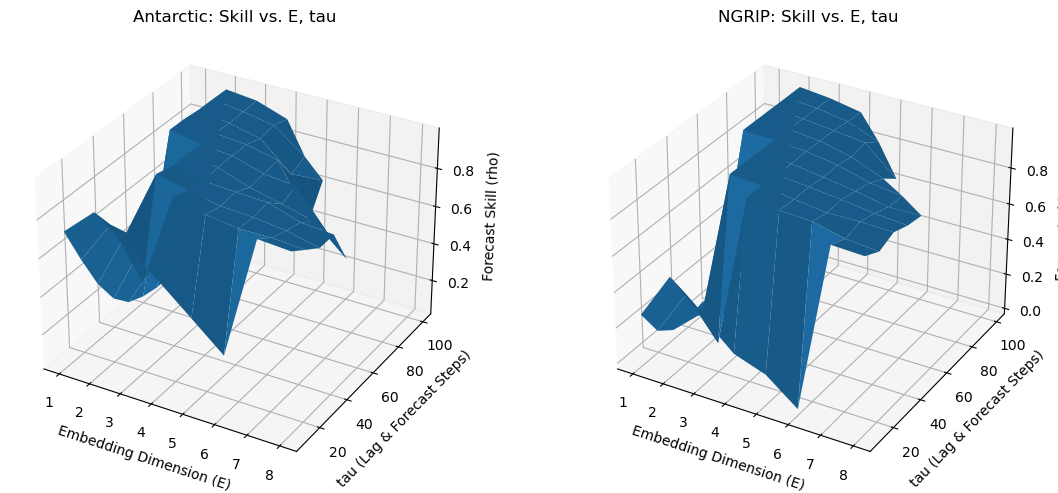

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Define parameter ranges
tau_values   = range(10, 101, 10)  # 10,20,30,...,100
E_candidates = range(1, 9)        # 1..8

# 2) We'll store results in 2D arrays:
#    rows = different tau, cols = different E
ant_results_3d   = np.zeros((len(tau_values), len(E_candidates)))
ngrip_results_3d = np.zeros((len(tau_values), len(E_candidates)))

# 3) Loop over tau, set Tp = tau, collect forecast skill for each E
for i, tau in enumerate(tau_values):
    # Antarctic
    ant_rho_dict = find_best_E(
        df_ant_edm,
        E_values    = E_candidates,
        data_column = 'd18O',
        tau         = tau,
        Tp          = tau,        # *** Same as tau
        lib         = '1 900',    # training range
        pred        = '901 1851', # testing range
        noTime      = False
    )
    # Fill rows in the matrix
    for j, E in enumerate(E_candidates):
        ant_results_3d[i, j] = ant_rho_dict[E]
    
    # NGRIP
    ngrip_rho_dict = find_best_E(
        df_ngrip_edm,
        E_values    = E_candidates,
        data_column = 'd18O',
        tau         = tau,
        Tp          = tau,
        lib         = '1 900',
        pred        = '901 1851',
        noTime      = False
    )
    for j, E in enumerate(E_candidates):
        ngrip_results_3d[i, j] = ngrip_rho_dict[E]

# 4) Create a 3D meshgrid for plotting
#    X-axis: E, Y-axis: tau
E_grid, Tau_grid = np.meshgrid(E_candidates, tau_values)

# 5) Plot in 3D: one subplot for Antarctic, one for NGRIP
fig = plt.figure(figsize=(12,5))

# -- Antarctic
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot_surface(E_grid, Tau_grid, ant_results_3d)
ax1.set_title('Antarctic: Skill vs. E, tau')
ax1.set_xlabel('Embedding Dimension (E)')
ax1.set_ylabel('tau (Lag & Forecast Steps)')
ax1.set_zlabel('Forecast Skill (rho)')

# -- NGRIP
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot_surface(E_grid, Tau_grid, ngrip_results_3d)
ax2.set_title('NGRIP: Skill vs. E, tau')
ax2.set_xlabel('Embedding Dimension (E)')
ax2.set_ylabel('tau (Lag & Forecast Steps)')
ax2.set_zlabel('Forecast Skill (rho)')

plt.tight_layout()
plt.show()


In [33]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

tau_values   = range(10, 101, 10)  # 10,20,30,...,100
E_candidates = range(1, 9)        # 1..8

# e.g. to create mesh for x=E, y=tau:
E_grid, Tau_grid = np.meshgrid(E_candidates, tau_values)  # each shape: (len(tau_values), len(E_candidates))


# Create a 1x2 grid of 3D subplots
fig = make_subplots(
    rows=1, cols=2, 
    specs=[[{'type': 'surface'}, {'type': 'surface'}]],
    subplot_titles=["Antarctic", "NGRIP"]
)

# -- Add the Antarctic surface (left subplot, row=1,col=1)
fig.add_trace(
    go.Surface(
        x=E_grid,          # embedding dimension
        y=Tau_grid,        # tau
        z=ant_results_3d,  # correlation skill
        colorscale='Viridis',
        name='Antarctic'
    ),
    row=1, col=1
)

# -- Add the NGRIP surface (right subplot, row=1,col=2)
fig.add_trace(
    go.Surface(
        x=E_grid,
        y=Tau_grid,
        z=ngrip_results_3d,
        colorscale='Viridis',
        name='NGRIP'
    ),
    row=1, col=2
)

# Update layout for each subplot’s axes and overall figure
fig.update_layout(
    title="Forecast Skill vs. E and tau (Tp = tau)",
    width=1200, height=600
)

# Customize the axis titles on each 3D subplot
fig.update_scenes(
    dict(
        xaxis_title="E (Embedding Dimension)",
        yaxis_title="tau (Lag & Forecast Steps)",
        zaxis_title="Forecast Skill (rho)"
    ),  # scene1 settings
    row=1, col=1
)
fig.update_scenes(
    dict(
        xaxis_title="E (Embedding Dimension)",
        yaxis_title="tau (Lag & Forecast Steps)",
        zaxis_title="Forecast Skill (rho)"
    ),  # scene2 settings
    row=1, col=2
)

fig.show()


    LibSize       X:Y       Y:X
0     100.0  0.422639  0.401852
1     200.0  0.450441  0.456989
2     300.0  0.456259  0.489194
3     400.0  0.462366  0.513872
4     500.0  0.466175  0.536283
5     600.0  0.467993  0.555399
6     700.0  0.470034  0.568989
7     800.0  0.471843  0.578173
8     900.0  0.475558  0.589296
9    1000.0  0.477548  0.597142
10   1100.0  0.478054  0.604882
11   1200.0  0.479822  0.609421
12   1300.0  0.481444  0.613548
13   1400.0  0.483066  0.617912
14   1500.0  0.484817  0.621315
15   1600.0  0.487419  0.624251
Columns: Index(['LibSize', 'X:Y', 'Y:X'], dtype='object')


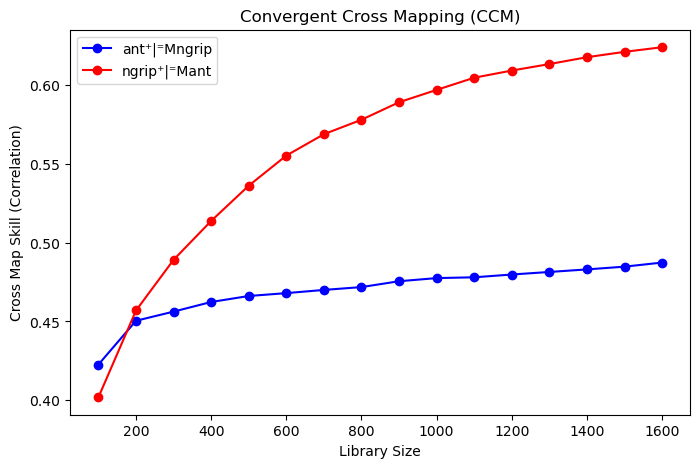

In [37]:

import pandas as pd
import numpy as np
from pyEDM import CCM
import matplotlib.pyplot as plt

# Prepare DataFrame
df = pd.DataFrame({
    'Time': new_time_axis,
    'X': detrended_d18O_ngrip,  # predictor: ngrip
    'Y': detrended_d18O_ant     # target: ant
})

# CCM call
ccm_out = CCM(
    dataFrame   = df,
    E           = 3,
    tau         = 50,
    columns     = "X",   # predictor (ngrip)
    target      = "Y",   # target (ant)
    libSizes    = "100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600",
    sample      = 100,
    random      = True,
    replacement = False,
    Tp          = 50,
    verbose     = True
)

print(ccm_out)
print("Columns:", ccm_out.columns)

# Plot the results with custom legend labels
plt.figure(figsize=(8,5))
# For X:Y: predictor is ngrip, target is ant -> label: "ant^|Mngrip"
plt.plot(ccm_out['LibSize'], ccm_out['X:Y'], 'bo-', label='Ant\u207A|\u207CMNGRIP')
# For Y:X: predictor is ant, target is ngrip -> label: "ngrip^|Mant"
plt.plot(ccm_out['LibSize'], ccm_out['Y:X'], 'ro-', label='NGRIP\u207A|\u207CMAnt')

plt.xlabel('Library Size')
plt.ylabel('Cross Map Skill (Correlation)')
plt.title('Convergent Cross Mapping (CCM)')
plt.legend(loc='best')
plt.show()


    LibSize       X:Y       Y:X
0     100.0  0.422639  0.401852
1     200.0  0.450441  0.456989
2     300.0  0.456259  0.489194
3     400.0  0.462366  0.513872
4     500.0  0.466175  0.536283
5     600.0  0.467993  0.555399
6     700.0  0.470034  0.568989
7     800.0  0.471843  0.578173
8     900.0  0.475558  0.589296
9    1000.0  0.477548  0.597142
10   1100.0  0.478054  0.604882
11   1200.0  0.479822  0.609421
12   1300.0  0.481444  0.613548
13   1400.0  0.483066  0.617912
14   1500.0  0.484817  0.621315
15   1600.0  0.487419  0.624251
Columns: Index(['LibSize', 'X:Y', 'Y:X'], dtype='object')


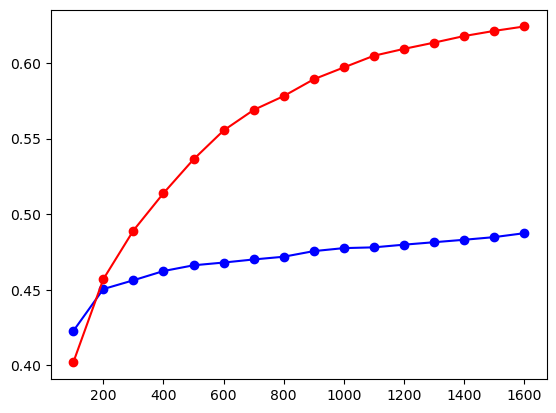

In [ ]:
import pandas as pd
import numpy as np
from pyEDM import CCM
import matplotlib.pyplot as plt


# Prepare DataFrame
df = pd.DataFrame({
    'Time': new_time_axis,
    'X': detrended_d18O_ngrip,
    'Y': detrended_d18O_ant
})



# CCM call
ccm_out = CCM(
    dataFrame   = df,
    E           = 3,
    tau         = 50,
    columns     = "X",   # predictor
    target      = "Y",   # target
    libSizes    = "100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600",
    sample      = 100,
    random      = True,
    replacement = False,
    Tp          = 50,
    verbose=True
)

print(ccm_out)
print("Columns:", ccm_out.columns)

# plot the results
plt.plot(ccm_out['LibSize'], ccm_out['X:Y'], 'bo-')
plt.plot(ccm_out['LibSize'], ccm_out['Y:X'], 'ro-')


   LibSize       X:Y       Y:X
0    200.0  0.451679  0.457055
1    400.0  0.462545  0.515302
2    600.0  0.469445  0.554101
3    800.0  0.470504  0.579614
4   1000.0  0.475149  0.597683
5   1200.0  0.479046  0.609183
6   1400.0  0.483173  0.618094
7   1600.0  0.487228  0.624327
Columns: Index(['LibSize', 'X:Y', 'Y:X'], dtype='object')


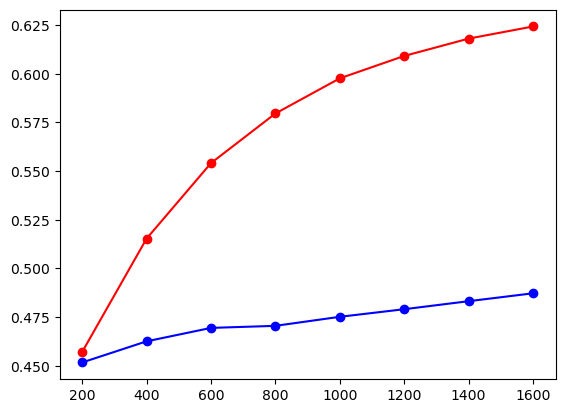

In [35]:
import pandas as pd
import numpy as np
from pyEDM import CCM
import matplotlib.pyplot as plt


# Prepare DataFrame
df = pd.DataFrame({
    'Time': new_time_axis,
    'X': detrended_d18O_ngrip,
    'Y': detrended_d18O_ant
})



# CCM call
ccm_out = CCM(
    dataFrame   = df,
    E           = 3,
    tau         = 50,
    columns     = "X",   # predictor
    target      = "Y",   # target
    libSizes    = "200 400 600 800 1000 1200 1400 1600",
    sample      = 200,
    random      = True,
    replacement = False,
    Tp          = 50
)

print(ccm_out)
print("Columns:", ccm_out.columns)

# plot the results
plt.plot(ccm_out['LibSize'], ccm_out['X:Y'], 'bo-')
plt.plot(ccm_out['LibSize'], ccm_out['Y:X'], 'ro-')

   LibSize       X:Y       Y:X
0    300.0  0.298023  0.484758
1    600.0  0.315350  0.556447
2    900.0  0.321053  0.596101
3   1200.0  0.324618  0.617274
4   1500.0  0.327660  0.631730
Columns: Index(['LibSize', 'X:Y', 'Y:X'], dtype='object')


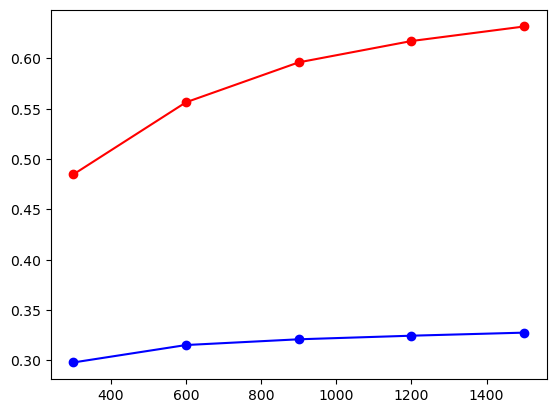

In [ ]:
import pandas as pd
import numpy as np
from pyEDM import CCM
import matplotlib.pyplot as plt


# Prepare DataFrame
df = pd.DataFrame({
    'Time': new_time_axis,
    'X': detrended_d18O_ngrip,
    'Y': detrended_d18O_ant
})



# CCM call
ccm_out = CCM(
    dataFrame   = df,
    E           = 3,
    tau         = 50,
    columns     = "X",   # predictor
    target      = "Y",   # target
    libSizes    = "300 600 900 1200 1500",
    sample      = 300,
    random      = True,
    replacement = False,
    Tp          = 50
)

print(ccm_out)
print("Columns:", ccm_out.columns)

# plot the results
plt.plot(ccm_out['LibSize'], ccm_out['X:Y'], 'bo-')
plt.plot(ccm_out['LibSize'], ccm_out['Y:X'], 'ro-')

# Find a proper tau value

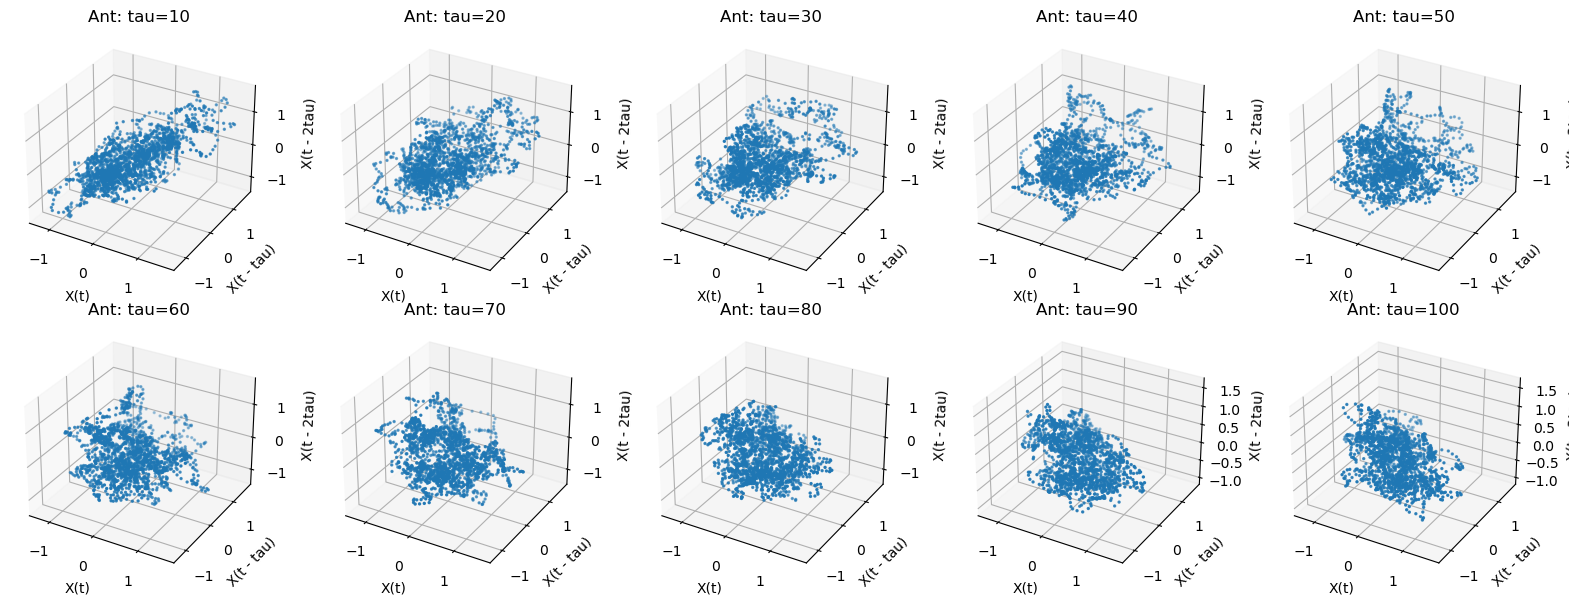

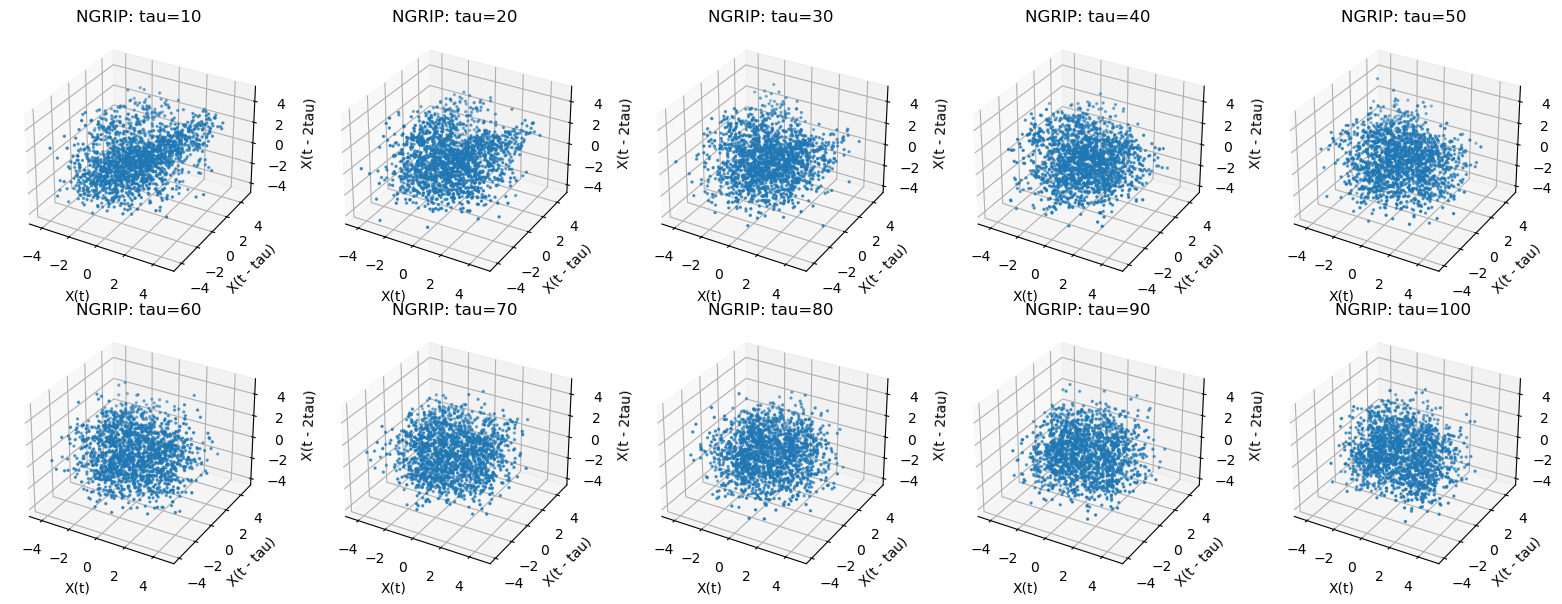

In [ ]:
import numpy as np
import matplotlib.pyplot as plt



def embed_3d(data, tau):
    """
    Embeds a 1D time series 'data' into 3D using the given lag 'tau'.
    Returns an array of shape (N, 3) where
      col0 = X(t),
      col1 = X(t - tau),
      col2 = X(t - 2*tau).
    We only keep valid indices (t >= 2*tau).
    """
    embedded = []
    # We need t - 2*tau >= 0, so t >= 2*tau
    for t in range(2 * tau, len(data)):
        embedded.append([
            data[t],
            data[t - tau],
            data[t - 2*tau]
        ])
    return np.array(embedded)

taus = range(10, 110, 10)  # 10, 20, 30, ..., 100

##############################################################################
# 1) 3D manifolds for ANTARCTIC data
##############################################################################
fig = plt.figure(figsize=(16, 6))  # wide figure to fit 2 x 5 subplots
for i, tau in enumerate(taus, start=1):
    ax = fig.add_subplot(2, 5, i, projection='3d')
    
    # Embed the Antarctic data
    emb = embed_3d(detrended_d18O_ant, tau)
    if emb.size == 0:
        # if data is too short for large tau
        continue
    
    ax.scatter(emb[:, 0], emb[:, 1], emb[:, 2], s=2)
    ax.set_title(f'Ant: tau={tau}')
    ax.set_xlabel('X(t)')
    ax.set_ylabel('X(t - tau)')
    ax.set_zlabel('X(t - 2tau)')

plt.tight_layout()
plt.show()

##############################################################################
# 2) 3D manifolds for NGRIP data
##############################################################################
fig = plt.figure(figsize=(16, 6))
for i, tau in enumerate(taus, start=1):
    ax = fig.add_subplot(2, 5, i, projection='3d')
    
    # Embed the NGRIP data
    emb = embed_3d(detrended_d18O_ngrip, tau)
    if emb.size == 0:
        continue
    
    ax.scatter(emb[:, 0], emb[:, 1], emb[:, 2], s=2)
    ax.set_title(f'NGRIP: tau={tau}')
    ax.set_xlabel('X(t)')
    ax.set_ylabel('X(t - tau)')
    ax.set_zlabel('X(t - 2tau)')

plt.tight_layout()
plt.show()
